In [108]:
import os
from collections import Counter

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import probscale
import itertools

from pathlib import Path

class Result:
    def __init__(self, name="sigmod", parallelism=3, rate=5, watermarks=False, iterations=10, distributed_acker=False, skip=0, stream_length=2000):
        self.name = name
        self.parallelism = parallelism
        self.distributed_acker = distributed_acker
        self.rate = rate
        self.watermarks = watermarks
        self.iterations = iterations
        self.skip = skip
        self.stream_length = stream_length

    def path(self):
        return Path(f"results/{self.name}/stream_length={self.stream_length}/parallelism={self.parallelism}/distributed_acker={self.distributed_acker}/rate={self.rate}/watermarks={self.watermarks}/iterations={self.iterations}/flamestream")
    
    def lat_data(self):
        with open(self.path().joinpath("latency/lat.data"), 'r') as file:
            return list(map(int, file.read().split(", ")))[self.skip:]
        
    def duration(self):
        with open(self.path().joinpath("duration.txt"), 'r') as file:
            return int(file.read())
        
    def durations(self):
        with open(self.path().joinpath("durations.txt"), 'r') as file:
            return list(map(int, file.read().split(", ")))[self.skip:]
    
    def throughput_hz(self, skip=0):
        durations = self.durations()
        return (len(durations) - skip) / (durations[-1] - durations[skip]) * 1E9

    def plot_latencies_evolution(self, window_size=100, q=0.95, stabilize=True):
        def each_slice(generator, n):
            group = []
            for element in generator:
                group.append(element)
                if len(group) == n:
                    yield group
                    group = []

            if group:
                yield group

        quantiles = []
        prev_quantile = None
        is_stable = not stabilize
        for window in each_slice(self.lat_data(), window_size):
            quantile = np.quantile(window, q)
            if is_stable:
                quantiles.append(quantile)
            elif prev_quantile and prev_quantile < quantile:
                is_stable = True
                quantiles.append(prev_quantile)
                quantiles.append(quantile)
            else:
                prev_quantile = quantile
            prev_window = window
        if not is_stable:
            raise "has not stabilized"
        plt.plot(quantiles)

def results_path(parallelism=3, rate=5, watermarks=False):
    return Path(f"results/sigmod/parallelism={parallelism}/distributed_acker={False}/rate={rate}/watermarks={watermarks}/iterations=10/flamestream")

def plot_probabilities(results_by_legends, legend_title=None, plot_title=None):
    fig, ax = plt.subplots(figsize=(10,10))
    for result in results_by_legends.values():
        plt.plot(*probscale.plot_pos(result.lat_data()))
    ax.legend(results_by_legends.keys(), title=legend_title)
    plt.xlabel('Percentile')
    plt.ylabel('Latency, ns')
    plt.title(plot_title)
    plt.show()
    
def plot_percentile(percentile, results_by_rates):
    fig, ax = plt.subplots(figsize=(10,10))
    plt.plot(
        results_by_rates.keys(),
        [np.percentile(result.lat_data(), percentile) for result in results_by_rates.values()]
    )
    plt.xlabel('Rate')
    plt.ylabel('Latency, ns')
    plt.show()
    
def plot_percentile_by_throughput(percentile, results):
    plt.plot(*plottable_percentile_by_throughput(percentile, results))
    
def plottable_percentile_by_throughput(percentile, results):
    return (
        [result.throughput() for result in results],
        [np.percentile(result.lat_data(), percentile) for result in results]
    )

def plot_throughput_by_number_of_iterations(results):
    plt.plot(
        [result.iterations for result in results],
        [result.throughput() for result in results],
    )
    
def show_max_throughput(result_factory, bad_rate, max_rate):
    pass

# Iterations = 5

## 99-я перцентиль задержек в зависимости от задержки между входными элементами (parallelism=3, Acker)

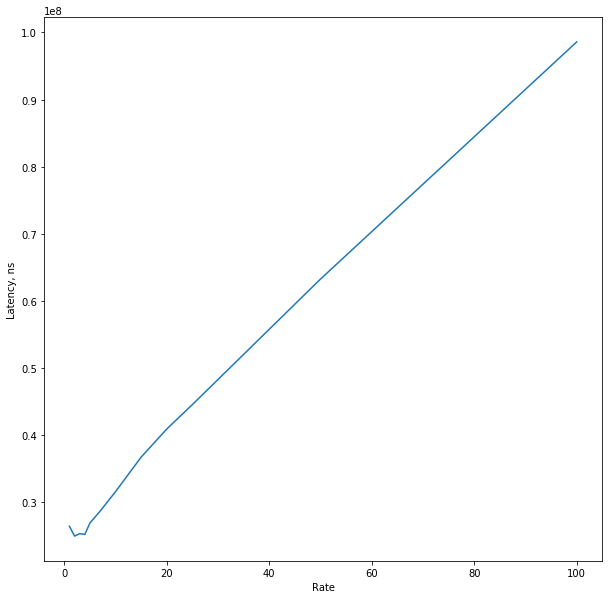

In [138]:
plot_percentile(90, {
    rate: Result(rate=rate, iterations=5)
    for rate in [1, 2, 3, 4, 5, 7, 10, 15, 20, 25, 50, 100]
})

## 99-я перцентиль задержек в зависимости от задержки между входными элементами (parallelism=3, Watermarks)

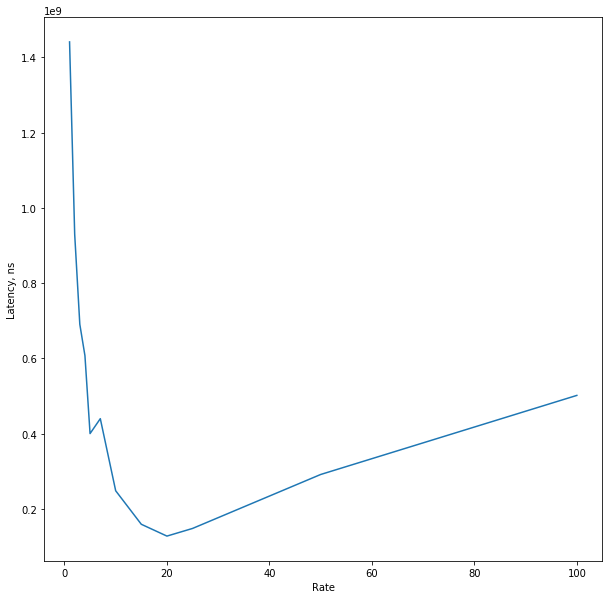

In [111]:
plot_percentile(99, {
    rate: Result(rate=rate, iterations=5, watermarks=True)
    for rate in [1, 2, 3, 4, 5, 7, 10, 15, 20, 25, 50, 100]
})

## 99-я перцентиль задержек в зависимости от задержки между входными элементами (parallelism=2, Acker)

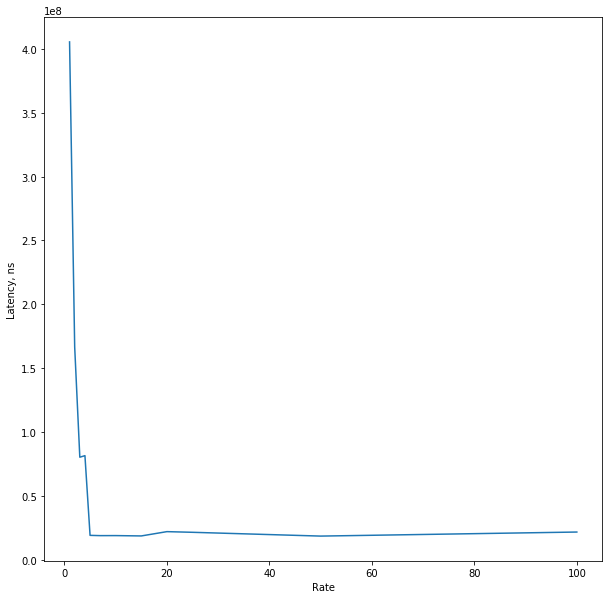

In [162]:
# plot_probabilities({
#     rate: Result(rate=rate, iterations=5, parallelism=2)
#     for rate in [1, 2, 3, 4, 5, 7, 10, 15, 20, 25, 50, 100]
# })
plot_percentile(97, {
    rate: Result(rate=rate, iterations=5, parallelism=2)
    for rate in [1, 2, 3, 4, 5, 7, 10, 15, 20, 25, 50, 100]
})

## 99-я перцентиль задержек в зависимости от задержки между входными элементами (parallelism=2, Watermarks)

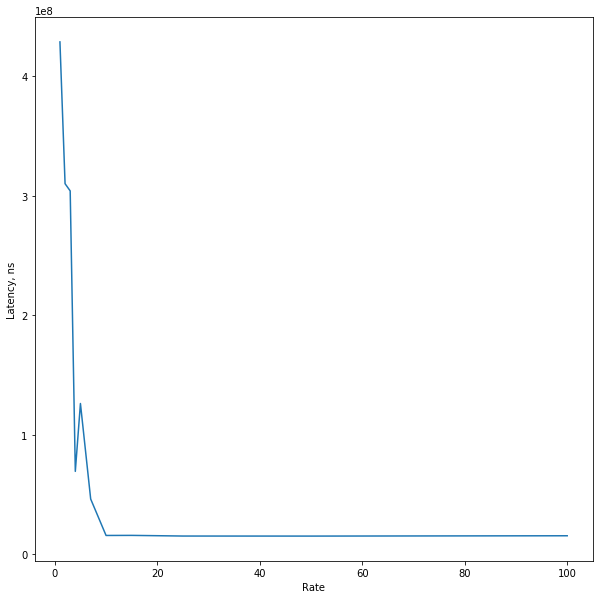

In [160]:
# plot_probabilities({
#     rate: Result(rate=rate, iterations=5, parallelism=2, watermarks=True)
#     for rate in [1, 2, 3, 4, 5, 7, 10, 15, 20, 25, 50, 100]
# })
plot_percentile(97, {
    rate: Result(rate=rate, iterations=5, parallelism=2, watermarks=True)
    for rate in [1, 2, 3, 4, 5, 7, 10, 15, 20, 25, 50, 100]
})

## 99-я перцентиль задержек в зависимости от задержки между входными элементами (parallelism=1, Acker)

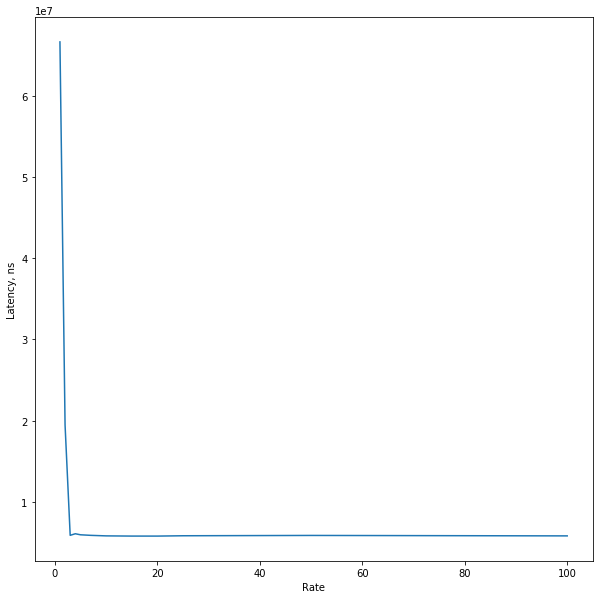

In [161]:
plot_percentile(99, {
    rate: Result(rate=rate, iterations=5, parallelism=1)
    for rate in [1, 2, 3, 4, 5, 7, 10, 15, 20, 25, 50, 100]
})

## 99-я перцентиль задержек в зависимости от задержки между входными элементами (parallelism=1, Watermarks)

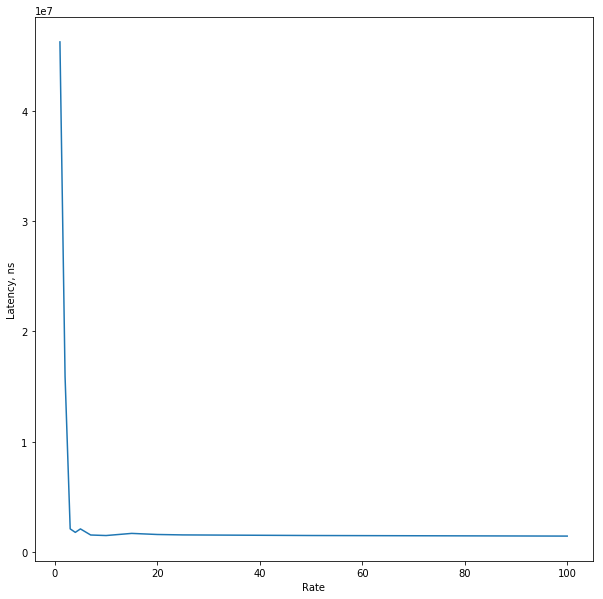

In [140]:
plot_percentile(99, {
    rate: Result(rate=rate, iterations=5, parallelism=1, watermarks=True)
    for rate in [1, 2, 3, 4, 5, 7, 10, 15, 20, 25, 50, 100]
})

## Throughput в зависимости от параллелизма

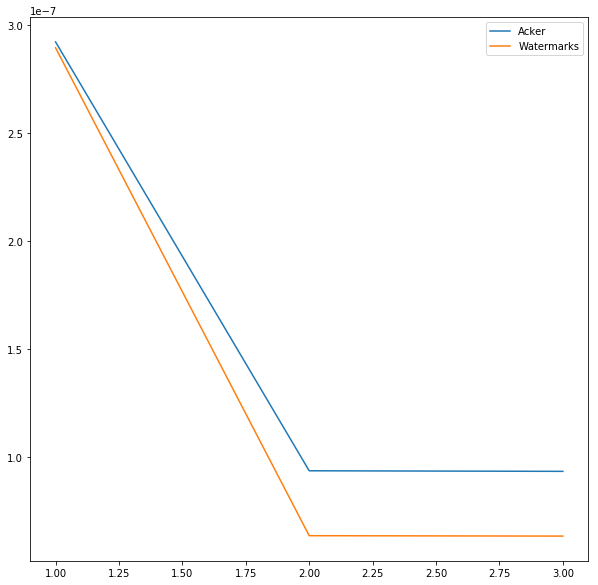

In [116]:
def plot_rate_throughput(result_by_parallelism):
    plt.plot(
        result_by_parallelism.keys(), 
        list(map(
            lambda a: 2000 / a.duration(),
            result_by_parallelism.values(),
        )),
    )


fig, ax = plt.subplots(figsize=(10,10))
plot_rate_throughput({
    1: Result(rate=3, parallelism=1),
    2: Result(rate=10, parallelism=2),
    3: Result(rate=10, parallelism=3),
})
plot_rate_throughput({
    1: Result(rate=3, parallelism=1, watermarks=True),
    2: Result(rate=15, parallelism=2, watermarks=True),
    3: Result(rate=15, parallelism=3, watermarks=True),
})
ax.legend(["Acker", "Watermarks"])

# Iterations = 10

## 99-я перцентиль задержек в зависимости от задержки между входными элементами (parallelism=3, Acker)

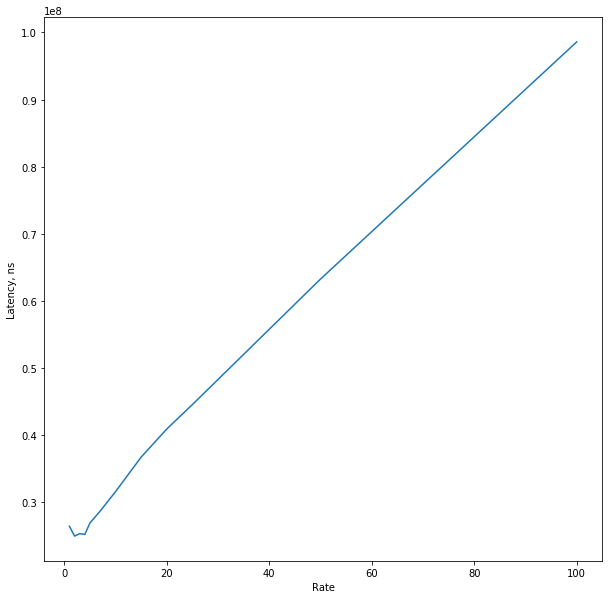

In [138]:
plot_percentile(90, {
    rate: Result(rate=rate)
    for rate in [1, 2, 3, 4, 5, 7, 10, 15, 20, 25, 50, 100]
})

## 99-я перцентиль задержек в зависимости от задержки между входными элементами (parallelism=3, Watermarks)

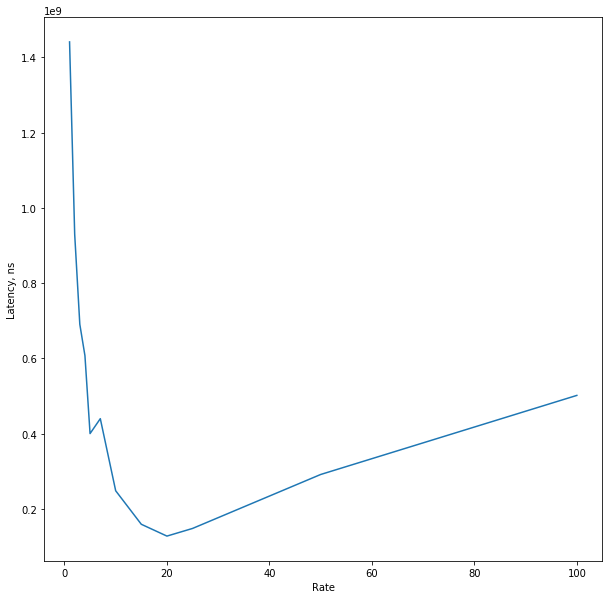

In [111]:
plot_percentile(99, {
    rate: Result(rate=rate, watermarks=True)
    for rate in [1, 2, 3, 4, 5, 7, 10, 15, 20, 25, 50, 100]
})

## 99-я перцентиль задержек в зависимости от задержки между входными элементами (parallelism=2, Acker)

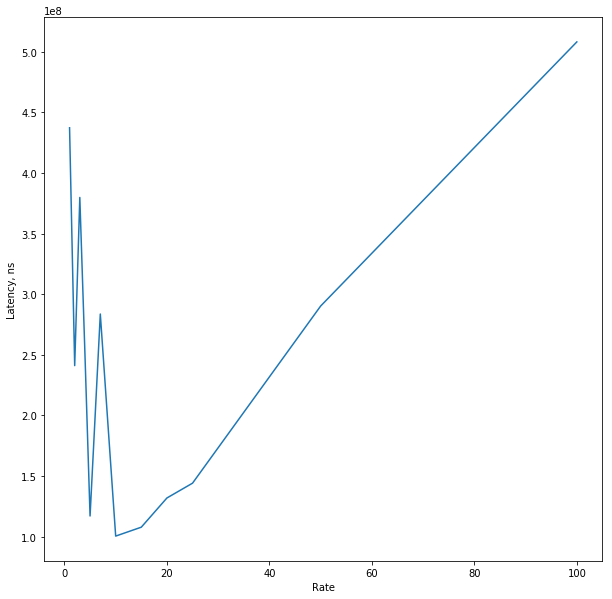

In [112]:
plot_percentile(99, {
    rate: Result(rate=rate, parallelism=2)
    for rate in [1, 2, 3, 4, 5, 7, 10, 15, 20, 25, 50, 100]
})

## 99-я перцентиль задержек в зависимости от задержки между входными элементами (parallelism=2, Watermarks)

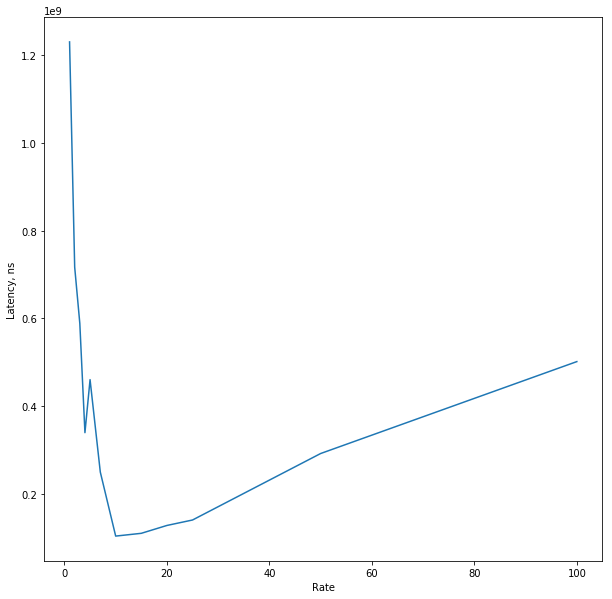

In [113]:
plot_percentile(99, {
    rate: Result(rate=rate, parallelism=2, watermarks=True)
    for rate in [1, 2, 3, 4, 5, 7, 10, 15, 20, 25, 50, 100]
})

## 99-я перцентиль задержек в зависимости от задержки между входными элементами (parallelism=1, Acker)

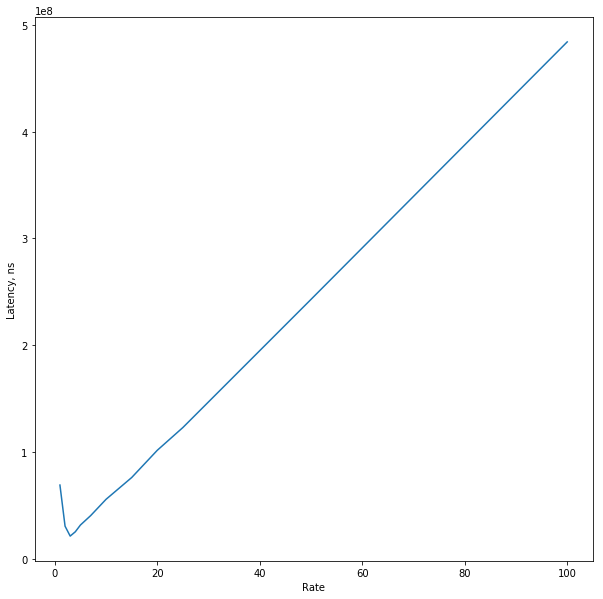

In [114]:
plot_percentile(99, {
    rate: Result(rate=rate, parallelism=1)
    for rate in [1, 2, 3, 4, 5, 7, 10, 15, 20, 25, 50, 100]
})

## 99-я перцентиль задержек в зависимости от задержки между входными элементами (parallelism=1, Watermarks)

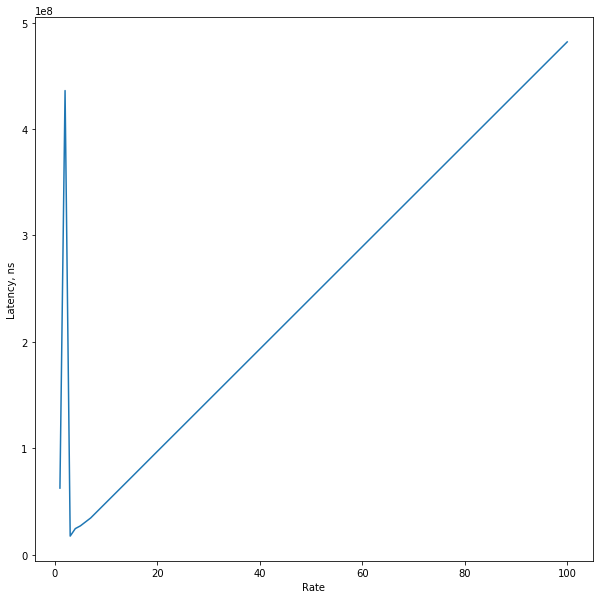

In [115]:
plot_percentile(99, {
    rate: Result(rate=rate, parallelism=1, watermarks=True)
    for rate in [1, 2, 3, 4, 5, 7, 10, 15, 20, 25, 50, 100]
})

## Throughput в зависимости от параллелизма

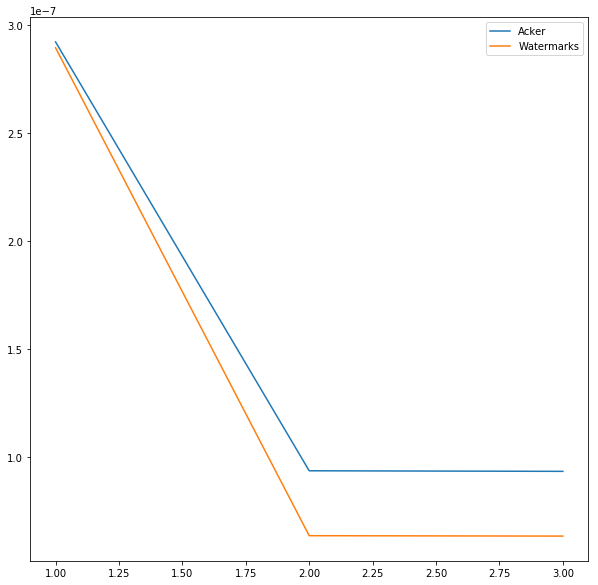

In [116]:
def plot_rate_throughput(result_by_parallelism):
    plt.plot(
        result_by_parallelism.keys(), 
        list(map(
            lambda a: 2000 / a.duration(),
            result_by_parallelism.values(),
        )),
    )


fig, ax = plt.subplots(figsize=(10,10))
plot_rate_throughput({
    1: Result(rate=3, parallelism=1),
    2: Result(rate=10, parallelism=2),
    3: Result(rate=10, parallelism=3),
})
plot_rate_throughput({
    1: Result(rate=3, parallelism=1, watermarks=True),
    2: Result(rate=15, parallelism=2, watermarks=True),
    3: Result(rate=15, parallelism=3, watermarks=True),
})
ax.legend(["Acker", "Watermarks"])

# Iterations=25

## 99-я перцентиль задержек в зависимости от задержки между входными элементами (parallelism=3, Acker)

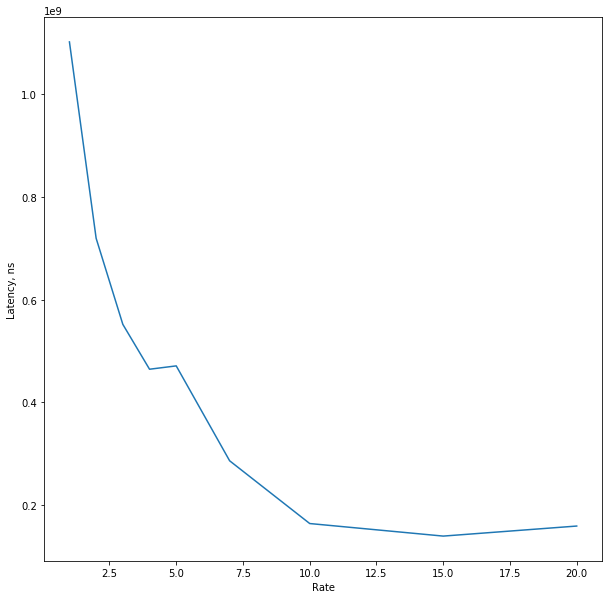

In [118]:
plot_percentile(99, {
    rate: Result(rate=rate, iterations=25)
    for rate in [1, 2, 3, 4, 5, 7, 10, 15, 20]
})

## 99-я перцентиль задержек в зависимости от задержки между входными элементами (parallelism=3, Watermarks)

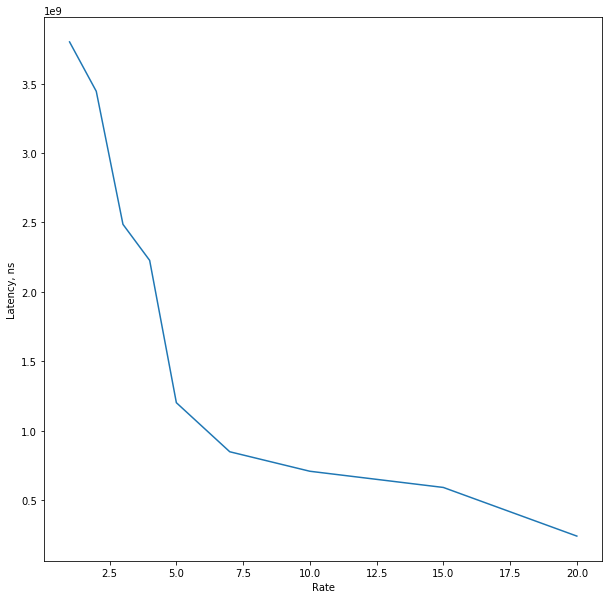

In [119]:
plot_percentile(99, {
    rate: Result(rate=rate, watermarks=True, iterations=25)
    for rate in [1, 2, 3, 4, 5, 7, 10, 15, 20]
})

## 99-я перцентиль задержек в зависимости от задержки между входными элементами (parallelism=2, Acker)

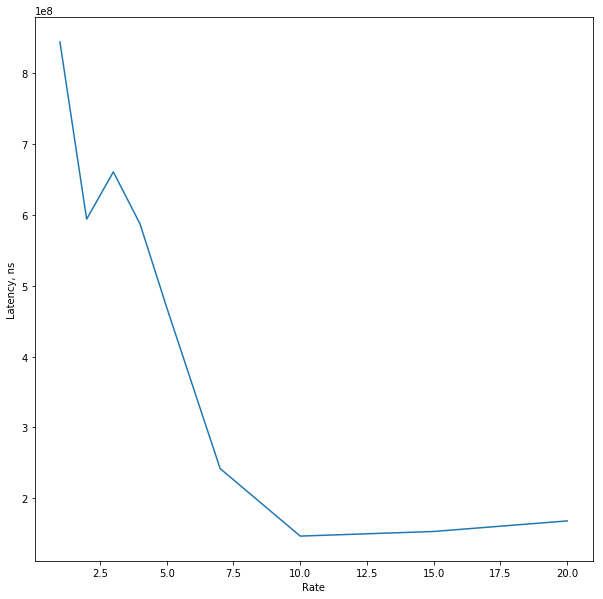

In [120]:
plot_percentile(99, {
    rate: Result(rate=rate, parallelism=2, iterations=25)
    for rate in [1, 2, 3, 4, 5, 7, 10, 15, 20]3
})

## 99-я перцентиль задержек в зависимости от задержки между входными элементами (parallelism=2, Watermarks)

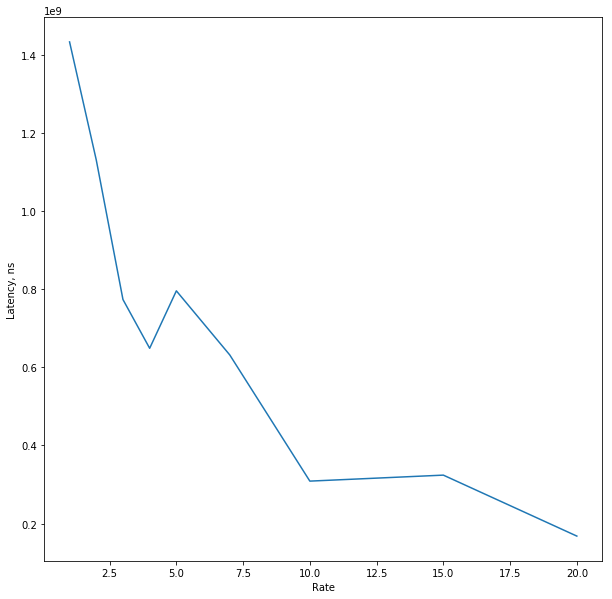

In [121]:
plot_percentile(99, {
    rate: Result(rate=rate, parallelism=2, watermarks=True, iterations=25)
    for rate in [1, 2, 3, 4, 5, 7, 10, 15, 20]
})

## 99-я перцентиль задержек в зависимости от задержки между входными элементами (parallelism=1, Acker)

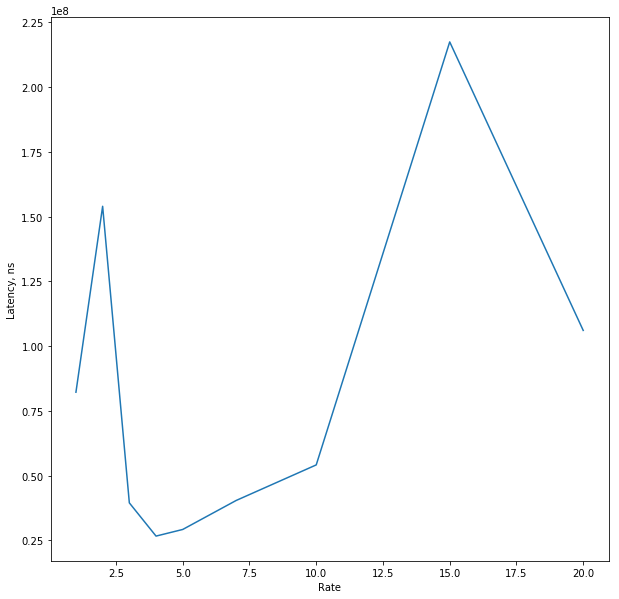

In [122]:
plot_percentile(99, {
    rate: Result(rate=rate, parallelism=1, iterations=25)
    for rate in [1, 2, 3, 4, 5, 7, 10, 15, 20]
})

## 99-я перцентиль задержек в зависимости от задержки между входными элементами (parallelism=1, Watermarks)

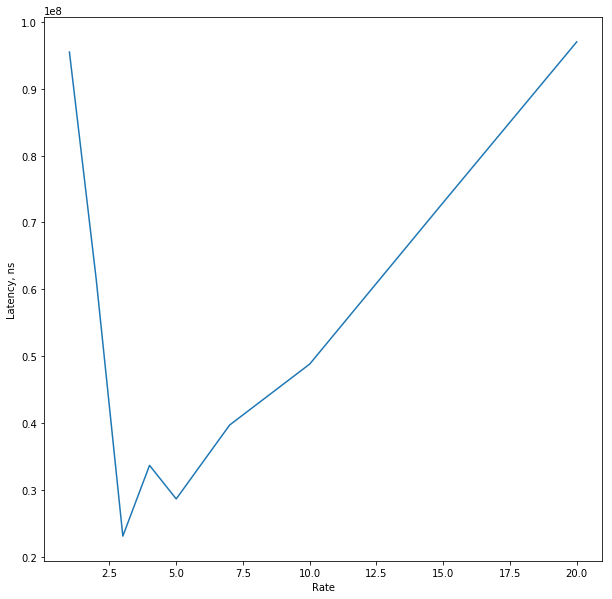

In [125]:
plot_percentile(99, {
    rate: Result(rate=rate, parallelism=1, watermarks=True, iterations=25)
    for rate in [1, 2, 3, 4, 5, 7, 10, 15, 20]
})

## Throughput в зависимости от параллелизма

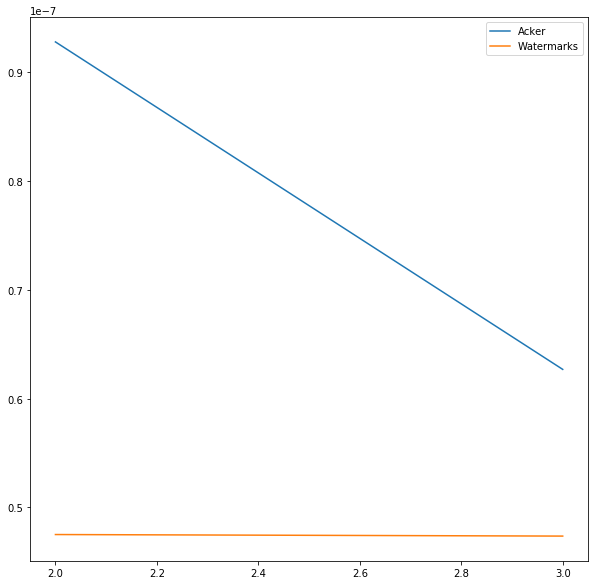

In [126]:
def plot_rate_throughput(result_by_parallelism):
    plt.plot(
        result_by_parallelism.keys(), 
        list(map(
            lambda a: 2000 / a.duration(),
            result_by_parallelism.values(),
        )),
    )


fig, ax = plt.subplots(figsize=(10,10))
plot_rate_throughput({
    2: Result(rate=10, parallelism=2, iterations=25),
    3: Result(rate=15, parallelism=3, iterations=25),
})
plot_rate_throughput({
    2: Result(rate=20, parallelism=2, iterations=25, watermarks=True),
    3: Result(rate=20, parallelism=3, iterations=25, watermarks=True),
})
ax.legend(["Acker", "Watermarks"])

# Iterations = 100

## 99-я перцентиль задержек в зависимости от задержки между входными элементами (parallelism=3, Acker)

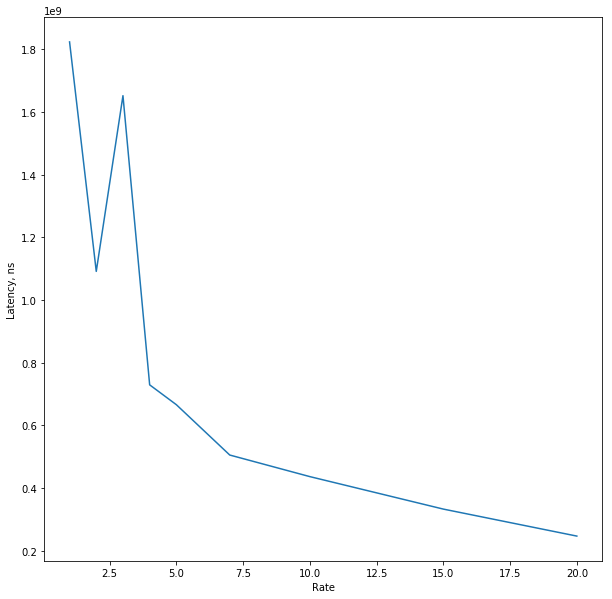

In [127]:
plot_percentile(99, {
    rate: Result(rate=rate, iterations=100)
    for rate in [1, 2, 3, 4, 5, 7, 10, 15, 20]
})

## 99-я перцентиль задержек в зависимости от задержки между входными элементами (parallelism=3, Watermarks)

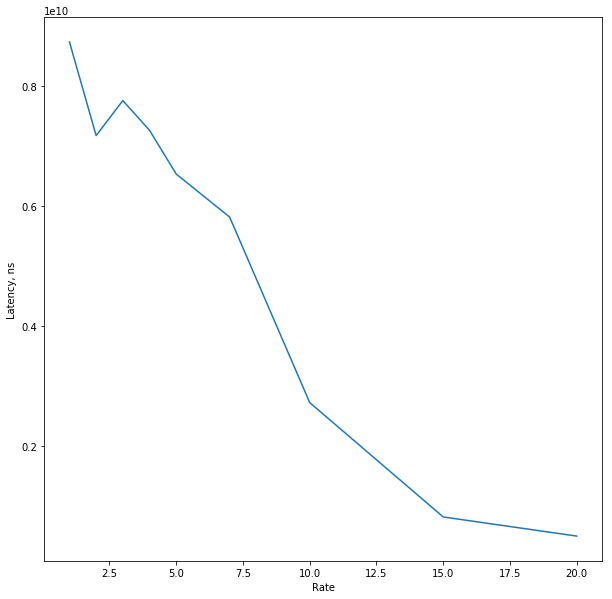

In [128]:
plot_percentile(99, {
    rate: Result(rate=rate, watermarks=True, iterations=100)
    for rate in [1, 2, 3, 4, 5, 7, 10, 15, 20]
})

## 99-я перцентиль задержек в зависимости от задержки между входными элементами (parallelism=2, Acker)

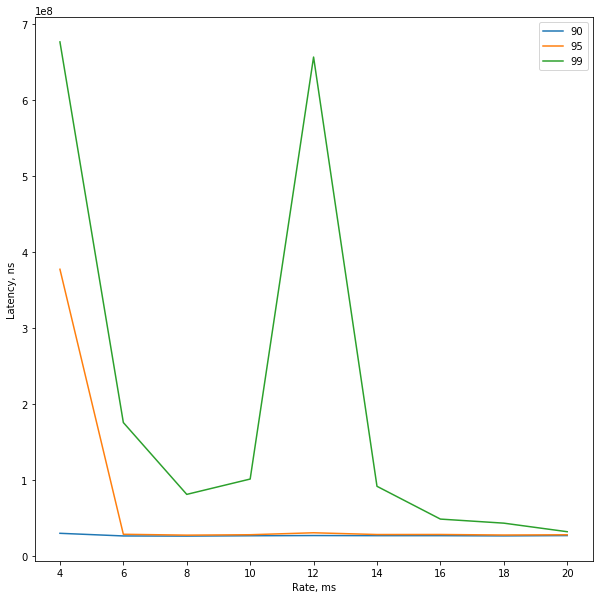

In [550]:
plt.subplots(figsize=(10,10))
iterations = 10
rates = range(20, 2, -2)

plot_percentile2(90, {
    rate: Result(name="sigmod.06.09.nightly", rate=rate, parallelism=3, distributed_acker=True, iterations=iterations)
    for rate in rates
})
plot_percentile2(95, {
    rate: Result(name="sigmod.06.09.nightly", rate=rate, parallelism=3, distributed_acker=True, iterations=iterations)
    for rate in rates
})
plot_percentile2(99, {
    rate: Result(name="sigmod.06.09.nightly", rate=rate, parallelism=3, distributed_acker=True, iterations=iterations)
    for rate in rates
})
plt.xlabel("Rate, ms")
plt.ylabel("Latency, ns")
plt.legend(["90", "95", "99"])
plt.show()

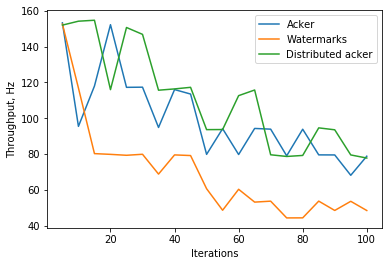

In [551]:
plot_throughput_by_number_of_iterations([
    Result(name="sigmod.06.08.nightly", rate=rate, parallelism=3, iterations=iterations) for iterations, rate in {
        100: 12,
        95: 14,
        90: 12,
        85: 12,
        80: 10,
        75: 12,
        70: 10,
        65: 10,
        60: 12,
        55: 10,
        50: 12,
        45: 8,
        40: 8,
        35: 10,
        30: 8,
        25: 8,
        20: 6,
        15: 8,
        10: 10,
        5: 6,
    }.items()
])
plot_throughput_by_number_of_iterations([
    Result(name="sigmod.06.08.nightly", rate=rate, parallelism=3, iterations=iterations, watermarks=True) for iterations, rate in {
        100: 20,
        95: 18,
        90: 20,
        85: 18,
        80: 22,
        75: 22,
        70: 18,
        65: 18,
        60: 16,
        55: 20,
        50: 16,
        45: 12,
        40: 12,
        35: 14,
        30: 12,
        25: 12,
        20: 12,
        15: 12,
        10: 8,
        5: 6,
    }.items()
])
plot_throughput_by_number_of_iterations([
    Result(name="sigmod.06.09.nightly", rate=rate, parallelism=3, iterations=iterations, distributed_acker=True) for iterations, rate in {
        100: 12,
        95: 12,
        90: 10,
        85: 10,
        80: 12,
        75: 12,
        70: 12,
        65: 8,
        60: 8,
        55: 10,
        50: 10,
        45: 8,
        40: 8,
        35: 8,
        30: 6,
        25: 6,
        20: 8,
        15: 6,
        10: 6,
        5: 6,
    }.items()
])
plt.xlabel("Iterations")
plt.ylabel("Throughput, Hz")
plt.legend(["Acker", "Watermarks", "Distributed acker"])

In [ ]:
## fig, ax = plt.subplots(figsize=(10,10))
plot_percentile_by_throughput(95, [
    Result(name="sigmod.06.08.nightly", rate=rate, parallelism=3, iterations=100)
    for rate in range(40, 4, -2)
])
plot_percentile_by_throughput(95, [
    Result(name="sigmod.06.08.nightly", rate=rate, parallelism=3, watermarks=True, iterations=100)
    for rate in range(40, 18, -2)
])
# plt.plot(*plottable_percentile_by_throughput(95, [
#     Result(rate=rate, parallelism=2, iterations=100)
#     for rate in [14]
# ]), "bo")
# plt.plot(*plottable_percentile_by_throughput(95, [
#     Result(rate=rate, parallelism=2, watermarks=True, iterations=100)
#     for rate in [14]
# ]), "ro")
print(plottable_percentile_by_throughput(95, [
    Result(rate=rate, parallelism=2, watermarks=False, iterations=100)
    for rate in [14]
])[1][0])
print(plottable_percentile_by_throughput(95, [
    Result(rate=rate, parallelism=2, watermarks=True, iterations=100)
    for rate in [14]
])[1][0])
plt.xlabel("Throughput, Hz")
plt.ylabel("Latency, ns")
plt.legend(["Acker", "Watermarks"])

## Throughput в зависимости от параллелизма

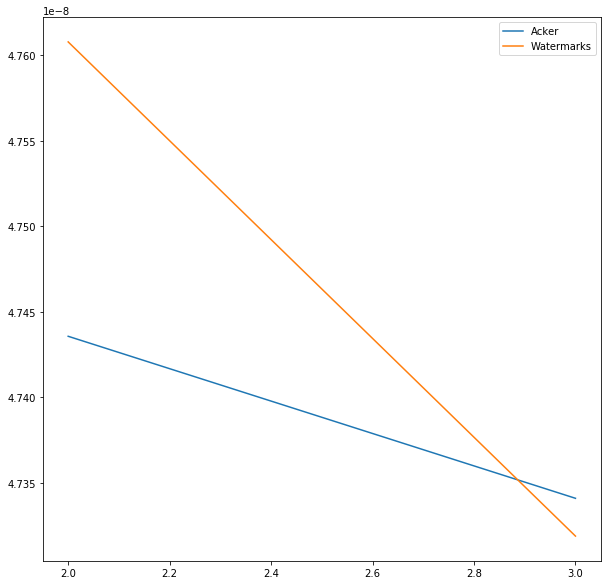

In [135]:
def plot_rate_throughput(result_by_parallelism):
    plt.plot(
        result_by_parallelism.keys(), 
        list(map(
            lambda a: 2000 / a.duration(),
            result_by_parallelism.values(),
        )),
    )


fig, ax = plt.subplots(figsize=(10,10))
plot_rate_throughput({
    2: Result(rate=20, parallelism=2, iterations=50),
    3: Result(rate=20, parallelism=3, iterations=50),
})
plot_rate_throughput({
    2: Result(rate=20, parallelism=2, iterations=50, watermarks=True),
    3: Result(rate=20, parallelism=3, iterations=50, watermarks=True),
})
ax.legend(["Acker", "Watermarks"])

## Throughput by rate

Text(0, 0.5, 'Latency, ns')

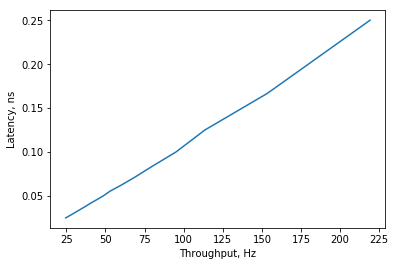

In [423]:
def plot_throughput_by_frequency(results):
    plt.plot(
        [result.throughput() for result in results],
        [1 / result.rate for result in results],
    )

plot_throughput_by_frequency([
    Result(name="sigmod.06.08.nightly", rate=rate, parallelism=3, iterations=45)
    for rate in range(40, 2, -2)
])
plt.xlabel("Throughput, Hz")
plt.ylabel("Latency, ns")

## 06.12

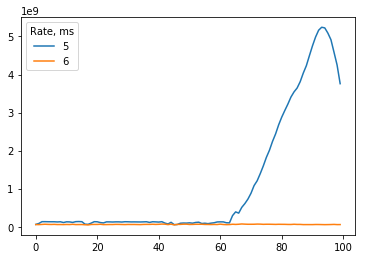

In [151]:
Result(
    name="sigmod.06.12", rate=5, parallelism=2, iterations=50, watermarks=True, stream_length=10000
).plot_latencies_evolution(q=0.5, stabilize=False)
Result(
    name="sigmod.06.12", rate=6, parallelism=2, iterations=50, watermarks=True, stream_length=10000
).plot_latencies_evolution(q=0.5, stabilize=False)
plt.legend([5, 6], title="Rate, ms")

89.29963671381029

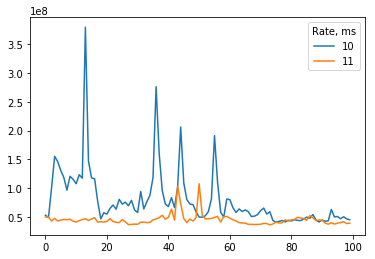

In [122]:
Result(
    name="sigmod.06.12", rate=10, parallelism=5, iterations=50, watermarks=True, stream_length=10000
).plot_latencies_evolution(q=0.5, stabilize=False)
Result(
    name="sigmod.06.12", rate=11, parallelism=5, iterations=50, watermarks=True, stream_length=10000
).plot_latencies_evolution(q=0.5, stabilize=False)
plt.legend([10, 11], title="Rate, ms")

44.998587249283936

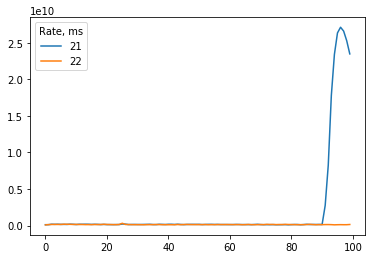

In [133]:
Result(
    name="sigmod.06.12", rate=21, parallelism=10, iterations=50, watermarks=True, stream_length=10000
).plot_latencies_evolution(q=0.5, stabilize=False)
Result(
    name="sigmod.06.12", rate=22, parallelism=10, iterations=50, watermarks=True, stream_length=10000
).plot_latencies_evolution(q=0.5, stabilize=False)
plt.legend([21, 22], title="Rate, ms")

314.0233589003596

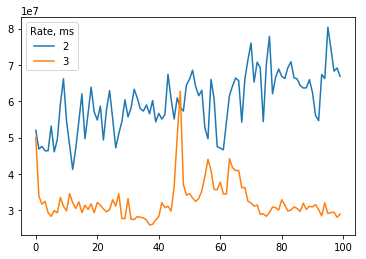

In [141]:
Result(
    name="sigmod.06.12", rate=2, parallelism=2, iterations=50, watermarks=False, stream_length=10000
).plot_latencies_evolution(q=0.5, stabilize=False)
Result(
    name="sigmod.06.12", rate=3, parallelism=2, iterations=50, watermarks=False, stream_length=10000
).plot_latencies_evolution(q=0.5, stabilize=False)
plt.legend([2, 3], title="Rate, ms")

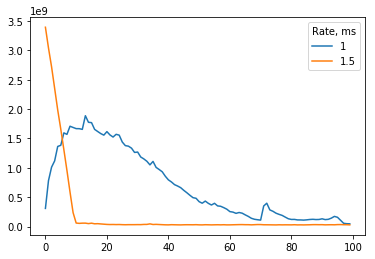

In [149]:
Result(
    name="sigmod.06.12", rate=1, parallelism=5, iterations=50, watermarks=False, stream_length=10000
).plot_latencies_evolution(q=0.5, stabilize=False)
Result(
    name="sigmod.06.12", rate=1.5, parallelism=5, iterations=50, watermarks=False, stream_length=10000
).plot_latencies_evolution(q=0.5, stabilize=False)
plt.legend([1, 1.5], title="Rate, ms")

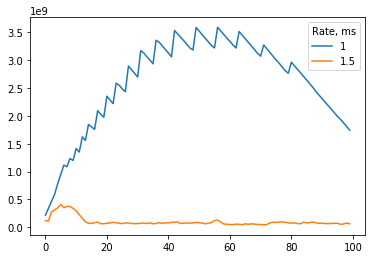

In [150]:
Result(
    name="sigmod.06.12", rate=0.5, parallelism=10, iterations=50, watermarks=False, stream_length=10000
).plot_latencies_evolution(q=0.5, stabilize=False)
Result(
    name="sigmod.06.12", rate=1, parallelism=10, iterations=50, watermarks=False, stream_length=10000
).plot_latencies_evolution(q=0.5, stabilize=False)
plt.legend([1, 1.5], title="Rate, ms")

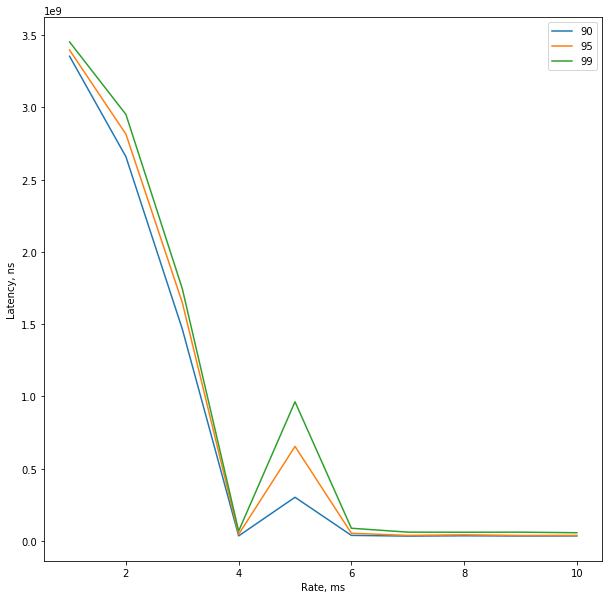

In [851]:
plt.subplots(figsize=(10,10))
iterations = 20
rates = list(range(10, 0, -1))
distributed_acker = False
parallelism = 10
name = "sigmod-aws.06.10"
# name = "sigmod.06.11.nightly"
skip = 500
stream_length = 10000

plot_percentile2(90, {
        rate: Result(name=name, rate=rate, parallelism=parallelism, distributed_acker=distributed_acker, iterations=iterations, skip=skip, stream_length=stream_length)
    for rate in rates
})
plot_percentile2(95, {
        rate: Result(name=name, rate=rate, parallelism=parallelism, distributed_acker=distributed_acker, iterations=iterations, skip=skip, stream_length=stream_length)
    for rate in rates
})
plot_percentile2(99, {
        rate: Result(name=name, rate=rate, parallelism=parallelism, distributed_acker=distributed_acker, iterations=iterations, skip=skip, stream_length=stream_length)
    for rate in rates
})
plt.xlabel("Rate, ms")
plt.ylabel("Latency, ns")
plt.legend(["90", "95", "99"])
plt.show()

In [ ]:
plot_throughput_by_number_of_iterations([
    Result(name="sigmod-aws.06.10", rate=rate, parallelism=10, iterations=iterations, distributed_acker=True) for iterations, rate in {
        100: 6,
        95: 6,
        90: 6,
        85: 6,
        50: 6,
        25: 6,
        5: 6,
    }.items()
])
plt.xlabel("Throughput, Hz")
plt.ylabel("Latency, ns")

In [ ]:
plot_throughput_by_number_of_iterations([
    Result(name="sigmod-aws.06.10", rate=rate, parallelism=10, iterations=iterations, distributed_acker=True) for iterations, rate in {
        100: 12,
        95: 12,
        90: 12,
        85: 12,
        80: 8,
        75: 8,
        70: 10,
        65: 8,
        60: 8,
        55: 6,
        50: 8,
        45: 12,
        40: 8,
        35: 10,
        30: 10,
        25: 10,
        20: 6,
        15: 6,
        10: 6,
        5: 6,
    }.items()
])
plt.xlabel("Throughput, Hz")
plt.ylabel("Latency, ns")